## Äänirauta

- simulaatiota laser ihmisille
    - https://www.geogebra.org/m/bdbbcWwb

<tr>
<td>
**Tausta**
<img src="r1.png" style="width: 400px">
</td>
<td>
**Värähtely**
<img src="r2.png" style="width: 400px">
</td>
</tr>

In [4]:
# Ladataan oleelliset paketit

import numpy as np
import matplotlib.pyplot as plt

import skimage
from skimage import io
from skimage import exposure
from skimage.filters import threshold_minimum,threshold_otsu,threshold_mean

from scipy.signal import savgol_filter

In [5]:
# Ladataan kokeessa otetut kuvat muuttujiin
r1 = io.imread('r1.png',as_grey=True)
r2 = io.imread('r2.png',as_grey=True)

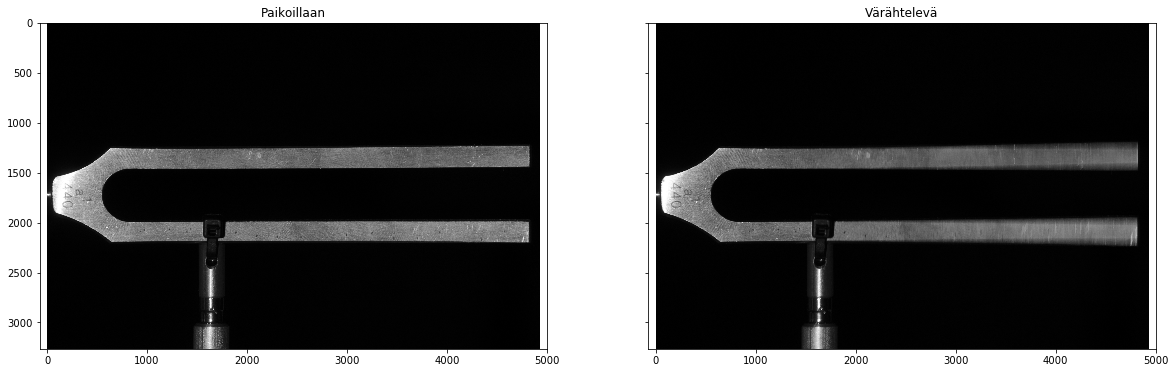

In [6]:
# Tarkistetaan, että kuvat ovat luettu muuttujiin
fig, ax = plt.subplots(ncols=2,
                       sharex=True,
                       sharey=True,
                       figsize=(20, 6))
ax[0].imshow(r1,cmap=plt.cm.gray)
ax[0].set_title('Paikoillaan')
ax[1].imshow(r2,cmap=plt.cm.gray)
ax[1].set_title('Värähtelevä')
plt.show()

In [7]:
# Cropataan kuvasta oleellinen osa tarkasteluun edellisen kuvan koordinaatiston perusteella
# valitaan välin vasen reuna siten, että äänirauta on haarautunut ja värähtelevän tangon pieni
# kulma rajautuu juuri pois. Oikea reuna siten, että äänirauta juuri loppuu.
cr1 = r1[1000:1400,625:4815]
cr2 = r2[1000:1400,625:4815]

In [8]:
# lisätään hieman erottelevuutta kuvaan
gr1 = exposure.adjust_sigmoid(cr1, 0.1)
gr2 = exposure.adjust_sigmoid(cr2, 0.1)

In [9]:
# muutetaan kuvan pistet vain mustiksi tai valkoisiksi
tr1 = threshold_minimum(gr1)
tr2 = threshold_minimum(gr2)
br1 = gr1 > tr1
br2 = gr2 > tr2

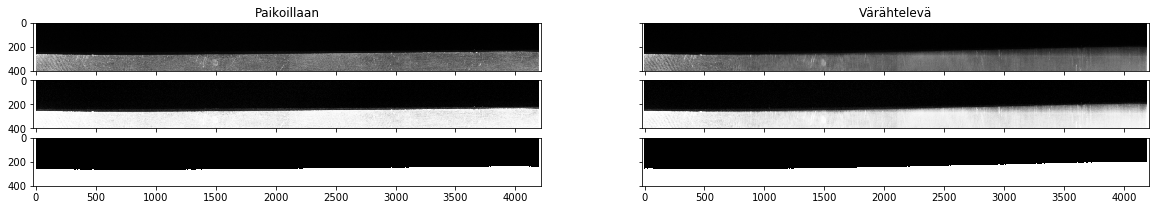

In [10]:
fig, ax = plt.subplots(ncols=2,
                       nrows=3,
                       sharex=True,
                       sharey=True,
                       figsize=(20, 3))
ax[0,0].set_title('Paikoillaan')
ax[0,1].set_title('Värähtelevä')
ax[0,0].imshow(cr1,cmap=plt.cm.gray)
ax[0,1].imshow(cr2,cmap=plt.cm.gray)
ax[1,0].imshow(gr1,cmap=plt.cm.gray)
ax[1,1].imshow(gr2,cmap=plt.cm.gray)
ax[2,0].imshow(br1,cmap=plt.cm.gray)
ax[2,1].imshow(br2,cmap=plt.cm.gray)
plt.show()

In [11]:
# tehdään taulut ääniraudan yläreunan sijainnille paikoillaan olevan ja värähtelevän tapauksessa
# pixeleinä etäisyys x-suunnassaja ja y-suunnassa referenssille (l) sekä värähtelylle (d) 
x = np.linspace(0,br1.shape[1]-1,br1.shape[1])
l = [0]*len(x)
d = [0]*len(x)

In [12]:
# etsitään kullakin x:n arvolla molemmissa kuvissa,
# missä kohtaa tulee ensimmäisen kerraan ylhäältä laskien äänirautaa
# huom kuvien koordinaatistossa y-suunta on invertoitu!
for j,b in enumerate(x):
    for i,br in enumerate(br1):
        if br[j] == True:
            l[j] = len(br1)-i
            break
    for i,br in enumerate(br2):
        if br[j] == True:
            d[j] = len(br2)-i
            break

In [13]:
# lasketaan värähtelevän ääniraudan maksimi siirtymä
w = np.asarray(d)-np.asarray(l)
smth_w = savgol_filter(w,1001,3)

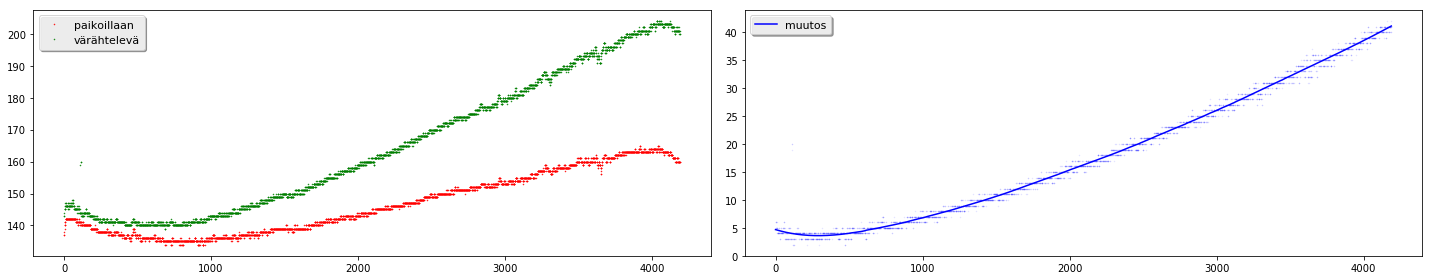

In [14]:
fig, ax = plt.subplots(ncols=2,
                       sharex=True,
                       figsize=(20, 4))
ax[0].plot(x,l,'r.',markersize=1, label="paikoillaan")
ax[0].plot(x,d,'g.',markersize=1, label="värähtelevä")
ax[0].legend(shadow=True, fontsize=11)
ax[1].plot(x,w,'b.',markersize=1,alpha=.1)
ax[1].plot(x,smth_w,'b-',label="muutos")
ax[1].legend(shadow=True, fontsize=11)
plt.tight_layout()
plt.show()

In [15]:
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [16]:
# teoreettinen tarkastelu rakennepalkin moodille 1
# asetetaan parametri B, sillä selkeästi systeemi on tuottanut
# pienen systemaattisen virheen, koska tulokset kiinnitys
# päässä ovat nollasta poikkeavia.
# mittaus ja teoreettiset vakiot
c = 0.59686

def displacement(x, *p):
    A,L,B = p
    b = c*np.pi/L
    return A*(np.cosh(b*x)-np.cos(b*x)+ (np.cosh(b*L)+np.cos(b*L))/(np.sinh(b*L)+np.sin(b*L))*(np.sin(b*x)-np.sinh(b*x)))+B

def chisq_displacement(p,x,y):
    A,L,B = p
    y_err = 2 # oletetaan datan perusteella 2 pixelin luetettavuus jokaiselle pisteelle
    return sum( (y-displacement(x,A,L,B))**2 / y_err**2 )

In [17]:
p_opt = minimize(
    chisq_displacement,
    [1,4000,5],
    args=(x,w),
    method='Nelder-Mead').x

In [28]:
# palkin pituus 92,4 mm
ratio = (92.4 / len(x))

In [29]:
x = np.asarray(x) * ratio
w = np.asarray(w) * ratio
smth_w = np.asarray(smth_w) * ratio

In [31]:
# sovitusparametrien arvot
p_opt[0] = p_opt[0]*ratio
p_opt[1] = p_opt[1]*ratio
p_opt[2] = p_opt[2]*ratio

In [32]:
# sovitusparametrien arvot
p_opt[0],p_opt[1],p_opt[2]

(0.42441087335064753, 94.76252120859219, 0.078517535292020491)

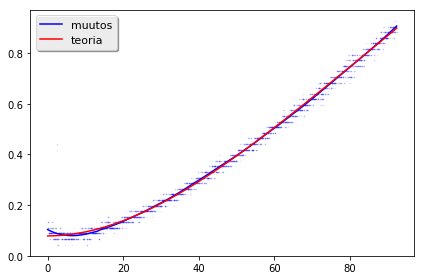

In [33]:
plt.plot(x,w,'b.',markersize=1,alpha=.1)
plt.plot(x,smth_w,'b-',label="muutos")
plt.plot(x,displacement(x,p_opt[0],p_opt[1],p_opt[2]),'r-',label="teoria")
plt.legend(shadow=True, fontsize=11)
plt.tight_layout()
plt.show()